In [1]:
import pymc as pm
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
with open('dataset.txt', 'r') as file:
    dataset = file.readlines()
    dataset = [document.strip('.\n') for document in dataset]
    dataset = np.array([document.split(' ') for document in dataset])
    print(dataset)

[['I', 'had', 'a', 'peanuts', 'butter', 'sandwich', 'for', 'breakfast']
 ['I', 'like', 'to', 'eat', 'almonds,', 'peanuts', 'and', 'walnuts']
 ['My', 'neighbor', 'got', 'a', 'little', 'dog', 'yesterday']
 ['Cats', 'and', 'dogs', 'are', 'mortal', 'enemies']
 ['You', 'mustn’t', 'feed', 'peanuts', 'to', 'your', 'dog']]


In [3]:
def transform_dataset(dataset=dataset):
    words_per_doc = [len(doc) for doc in dataset]
    flat_documents = [item for arr in dataset for item in arr]
    vocabulary, indices = np.unique(flat_documents, return_inverse=True)
    data = []
    i=0
    for w in range(len(words_per_doc)):
        data.append(indices[i:i + words_per_doc[w]])
        i = i + words_per_doc[w]
    return data, words_per_doc, vocabulary

In [4]:
data, words_per_doc, vocabulary = transform_dataset(dataset)
K = 2  # number of topics
V = len(vocabulary)  # number of words
D = len(data)  # number of documents

alpha = np.ones(K)
beta = np.ones(V)

In [5]:
theta = pm.Container([pm.CompletedDirichlet(
    "theta_%s" % i, pm.Dirichlet("ptheta_%s" % i, theta=alpha)) for i in range(D)]) 
phi = pm.Container([pm.CompletedDirichlet(
    "phi_%s" % k, pm.Dirichlet("pphi_%s" % k, theta=beta)) for k in range(K)])

Categorical distribution is Multinomial with only one trial

In [6]:
z = pm.Container([pm.Categorical('z_%i' % d,
                                 p=theta[d],
                                 size=words_per_doc[d])
                  for d in range(D)])
w = pm.Container([pm.Categorical("w_%i_%i" % (d, i),
                                  p=pm.Lambda('phi_z_%i_%i' % (d, i), lambda z=z[d][i], phi=phi: phi[z]),
                                 value=data[d][i],
                                 observed=True)
                  for d in range(D) for i in range(words_per_doc[d])])

In [7]:
model = pm.Model([theta, phi, z, w])
mcmc = pm.MCMC(model)
mcmc.sample(10000, 5000)

 [-----------------100%-----------------] 10000 of 10000 complete in 12.1 sec

In [8]:
theta.value

[array([[ 0.16334952,  0.83665048]]),
 array([[ 0.08934543,  0.91065457]]),
 array([[ 0.25455424,  0.74544576]]),
 array([[ 0.75144095,  0.24855905]]),
 array([[ 0.16372864,  0.83627136]])]

In [9]:
[f'Document {index} is {np.argmax(topic_distribution)} with {np.max(topic_distribution)}' for index, topic_distribution in enumerate(theta.value)]

['Document 0 is 1 with 0.8366504814480347',
 'Document 1 is 1 with 0.9106545714636556',
 'Document 2 is 1 with 0.7454457645275314',
 'Document 3 is 0 with 0.7514409485276375',
 'Document 4 is 1 with 0.8362713627816984']

In [10]:
def plot_topics_per_document(theta=theta.value, D=D, K=K):
    fig, ax = plt.subplots(D, figsize=(20, 20))
    fig.suptitle('Topic distribution per document')
    labels = ['Topic %i' % i for i in range(K)]

    for d in range(D):
        ax[d].pie(theta[d][0], labels=labels)
        ax[d].set_title('Document %i' % d)

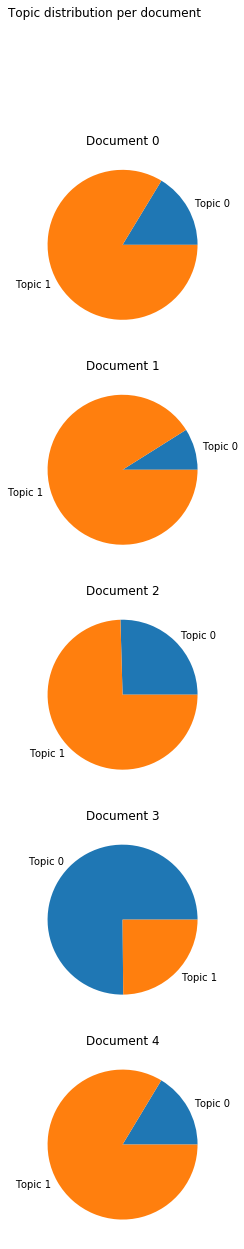

In [11]:
plot_topics_per_document(theta.value, D, K)

In [12]:
def plot_words_per_topic(phi=phi.value, K=K, labels=vocabulary):
    fig, ax = plt.subplots(K, figsize=(20, 20))
    fig.suptitle('Words probability to be in that topic')
    fig.legend(vocabulary)    
    for index in range(K):
        topic_distribution = phi[index]
        print(topic_distribution[0])
        ax[index].pie(topic_distribution[0], labels=labels)
        ax[index].set_title('topic %i' % index)

[ 0.0440503   0.0119286   0.0096141   0.00037363  0.11010629  0.04382143
  0.00712232  0.07141972  0.01713905  0.0140428   0.0376287   0.05112817
  0.01300128  0.02475341  0.03335421  0.0355232   0.01298239  0.02245411
  0.05300952  0.14055409  0.00069573  0.05245428  0.03305711  0.03127385
  0.00682764  0.03621045  0.01042235  0.04500956  0.03004172]
[ 0.04093797  0.03221524  0.0272849   0.10803391  0.0074804   0.02462449
  0.04599545  0.02264823  0.05011736  0.04907685  0.05351858  0.01442014
  0.07844853  0.00745706  0.04404737  0.03844551  0.01048323  0.02827602
  0.00498425  0.00257914  0.03482425  0.01769389  0.13830825  0.02383109
  0.01393039  0.02358153  0.02811816  0.00817089  0.02046692]


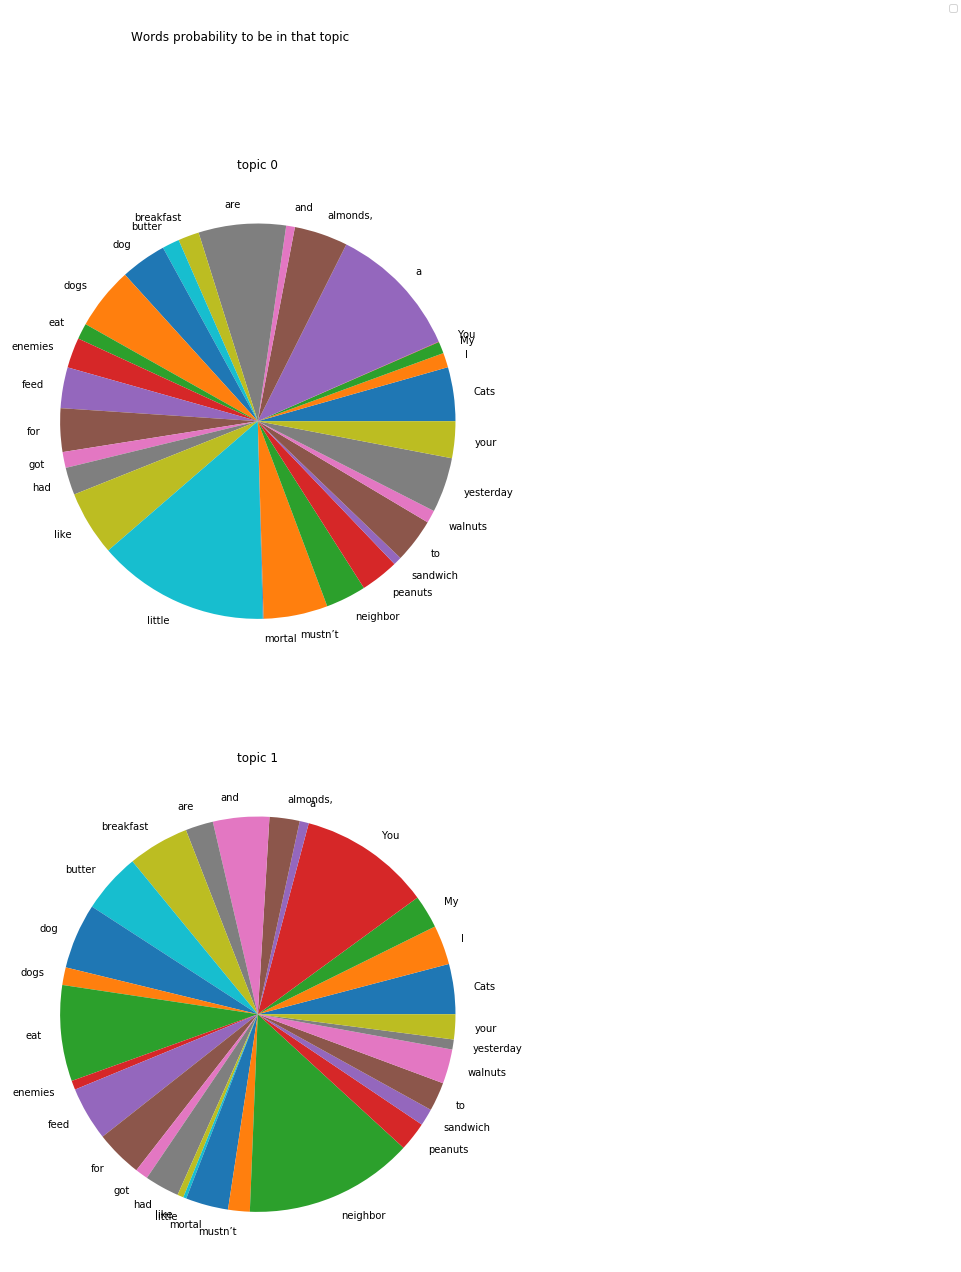

In [13]:
plot_words_per_topic(phi.value, K, vocabulary)

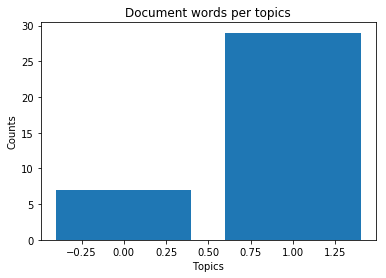

In [14]:
topic_dist = defaultdict(int)
for topic in z.value:
    for word in topic:
        topic_dist[word] += 1
        
fig, ax = plt.subplots(1, 1)
ax.bar(topic_dist.keys(), topic_dist.values())
ax.set_xlabel("Topics")
ax.set_ylabel("Counts")
ax.set_title("Document words per topics")
plt.show()

In [15]:
def compute_document_similarity(d1, d2, theta=theta.value):
    return np.sum(np.square(np.sqrt(theta[d1]) - np.sqrt(theta[d2])))

In [16]:
for i in range(D):
    for j in range(i, D):
        print(i,j, compute_document_similarity(i, j))
    print()

0 0 0.0
0 1 0.0126471404311
0 2 0.0127049030959
0 3 0.387247003683
0 4 2.62677737199e-07

1 1 0.0
1 2 0.0505433403473
1 3 0.530252578036
1 4 0.0127624947695

2 2 0.0
2 3 0.264382749115
2 4 0.0125898090882

3 3 0.0
3 4 0.38664100314

4 4 0.0



# Correlated Topic Model

In [17]:
data, words_per_doc, vocabulary = transform_dataset(dataset)
K = 2 # topics
mu = np.full(K, 1)
tau = np.full((K, K), 0.5)
V = len(vocabulary)
D = len(data)
beta = np.ones(V)

niu = pm.Container([pm.Normal('niu %i' %d, mu[0], tau[0]) for d in range(D)])
phi = pm.Container([pm.CompletedDirichlet(
    "phi_%s" % k, pm.Dirichlet("pphi_%s" % k, theta=beta)) for k in range(K)])

/home/mandark/.conda/envs/machine_learning/lib/python3.6/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(2, 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


In [18]:
niu.value

[array([ 0.60284024, -0.22477532]),
 array([ 2.76398981,  0.6784488 ]),
 array([ 1.70883489,  2.1213941 ]),
 array([ 5.08886004,  0.62189814]),
 array([ 1.27783221, -2.24283146])]

In [19]:
import math
def f_niu(niu):
    return np.exp(niu) / np.sum(np.exp(niu))

In [20]:
z = pm.Container([pm.Categorical('z_%i' % d,
                                 p=pm.Lambda('p_%i' % d, lambda niu=niu, d=d: f_niu(niu[d])),
                                 size=words_per_doc[d])
                  for d in range(D)])

In [21]:
w = pm.Container([pm.Categorical("w_%i_%i" % (d, i),
                                  p=pm.Lambda('phi_z_%i_%i' % (d, i), lambda z=z[d][i], phi=phi: phi[z]),
                                 value=data[d][i],
                                 observed=True)
                  for d in range(D) for i in range(words_per_doc[d])])

In [22]:
model = pm.Model([niu, phi, z, w])
mcmc = pm.MCMC(model)
mcmc.sample(10000, 5000)

 [-----------------100%-----------------] 10000 of 10000 complete in 17.9 sec

In [24]:
niu.value

[array([-1.63288292, -1.62008409]),
 array([-0.77077305,  1.20123506]),
 array([ 1.06329862,  1.43748413]),
 array([ 0.18438412,  2.03677834]),
 array([ 0.98279283,  3.45851461])]

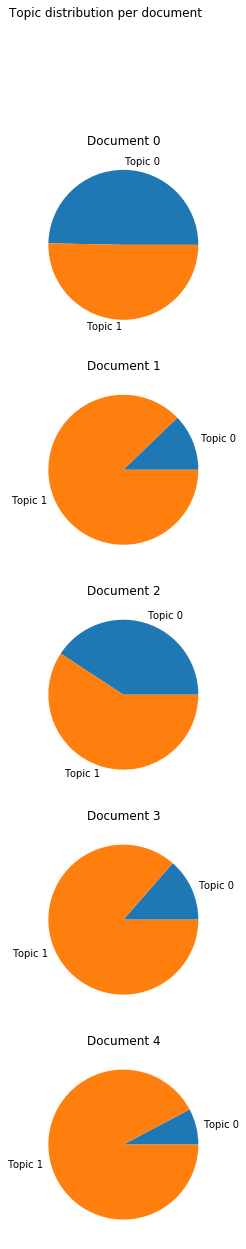

In [28]:
fig, ax = plt.subplots(D, figsize=(20, 20))
fig.suptitle('Topic distribution per document')
labels = ['Topic %i' % i for i in range(K)]

for d in range(D):
    ax[d].pie(f_niu(niu.value[d]), labels=labels)
    ax[d].set_title('Document %i' % d)

[ 0.0440503   0.0119286   0.0096141   0.00037363  0.11010629  0.04382143
  0.00712232  0.07141972  0.01713905  0.0140428   0.0376287   0.05112817
  0.01300128  0.02475341  0.03335421  0.0355232   0.01298239  0.02245411
  0.05300952  0.14055409  0.00069573  0.05245428  0.03305711  0.03127385
  0.00682764  0.03621045  0.01042235  0.04500956  0.03004172]
[ 0.04093797  0.03221524  0.0272849   0.10803391  0.0074804   0.02462449
  0.04599545  0.02264823  0.05011736  0.04907685  0.05351858  0.01442014
  0.07844853  0.00745706  0.04404737  0.03844551  0.01048323  0.02827602
  0.00498425  0.00257914  0.03482425  0.01769389  0.13830825  0.02383109
  0.01393039  0.02358153  0.02811816  0.00817089  0.02046692]


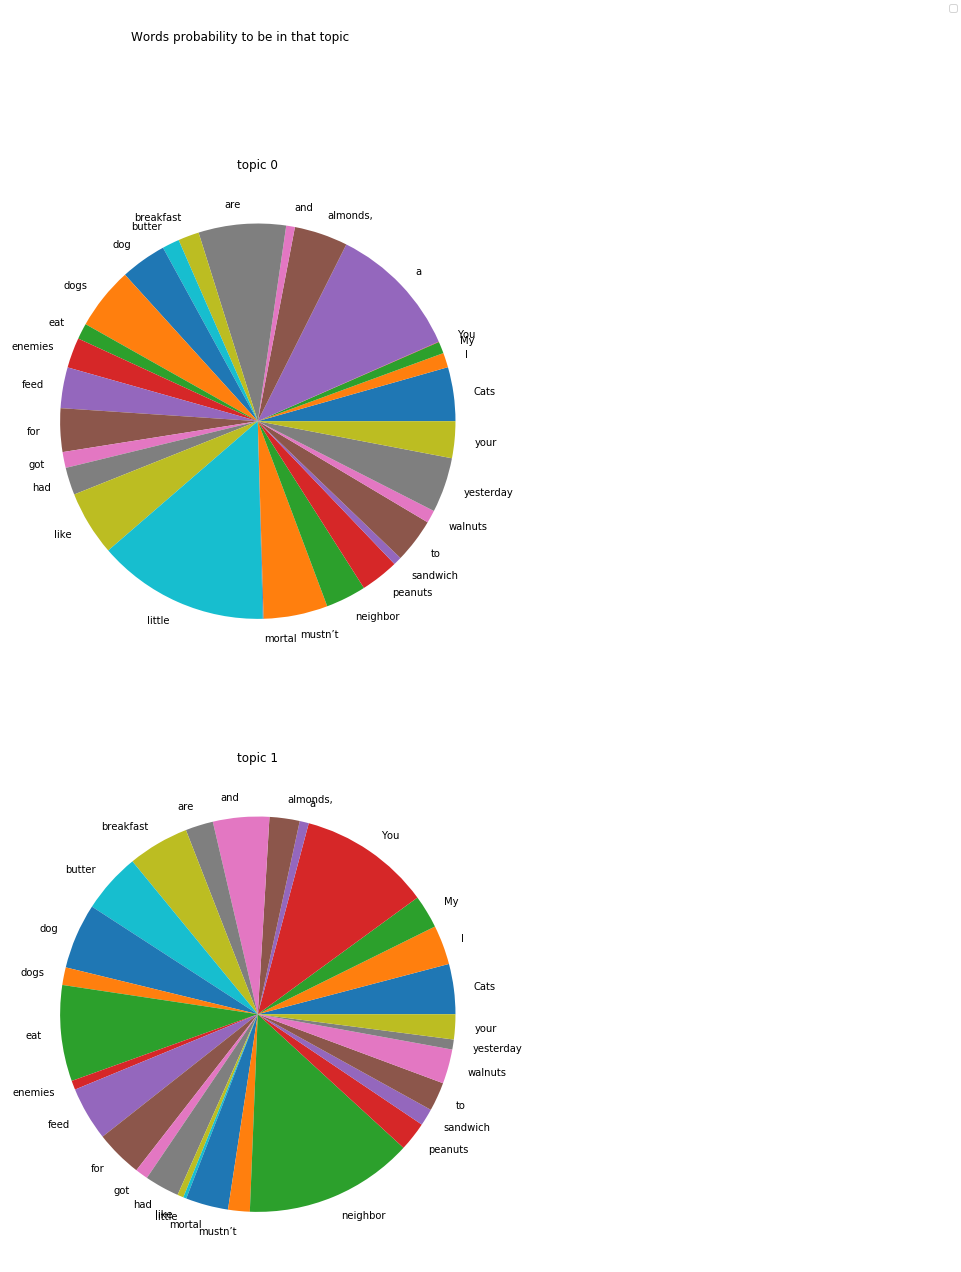

In [27]:
plot_words_per_topic()

# Dynamic topic model